# Kinship: Compute Cumulative Gain of RESCAL and BRESCAL

* Train BayesianRESCAL (BRESCAL) and RESCAL on the fully observed tensor
* Reconstruct tensor by using the trained BRESCAL and RESCAL
* At each time $t$, pull an entry of maximum value from the reconstructed tensor, and then compute the gain $r_t$

**Gains computed by the reconstructed tensor can be considered as a lower bound (not exact) of the gain we can archive through the particle Thompson sampling**, since the tensor is reconstructed by the model trained with fully observed tensor.

In [1]:
import os
import sys
import pickle
import numpy as np
from scipy.io.matlab import loadmat
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import itertools

import rescal
from brescal import BayesianRescal
from seq_brescal import PFBayesianRescal, compute_regret

%matplotlib inline

mat = loadmat('../data/alyawarradata.mat')
T = np.array(mat['Rs'], np.float32)
T = np.swapaxes(T, 1, 2)
T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]

In [15]:
budget = 30000
max_iter = 20
n_dim = 10
var_e = 1
var_r = 1
var_x = 0.1

X = [csr_matrix(T[k]) for k in range(T.shape[0])]
A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim)
_X = np.zeros_like(T)
for k in range(T.shape[0]):
    _X[k] = np.dot(np.dot(A, R[k]), A.T)

model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r)
model.fit(T, max_iter=max_iter)
_T = model._reconstruct()

seq_brescal = list()
seq_rescal = list()
for i in range(budget):
    idx = np.unravel_index(_T.argmax(), _T.shape)
    seq_brescal.append(idx)
    _T[idx] = -1000000
    idx = np.unravel_index(_X.argmax(), _X.shape)
    seq_rescal.append(idx)
    _X[idx] = -1000000

regret_brescal = compute_regret(T, seq_brescal)
regret_rescal = compute_regret(T, seq_rescal)
gain_brescal=1-np.array(regret_brescal)
gain_rescal=1-np.array(regret_rescal)

## Compute Cumulative Gain of Particle Thompson 

In [16]:
varxs = [0.1, 0.01]
n_dims = [5, 10]
n_particles = [5, 10]
n_test = 10

dest = '../result/kinship/'
summary = dict()

for var_x, nt, n_dim, n_particle in itertools.product(varxs, range(n_test), n_dims, n_particles):
    file = os.path.join(dest, 'sRESCAL_varx_%.2f_dim_%d_par_%d_test_%d_convar_False.txt' % (var_x, n_dim, n_particle, nt))
    if os.path.exists(file):
        seq = [line.split(',') for line in open(file, 'r').readlines()]
        key = (var_x, n_dim, n_particle)    
        cum_sum = np.cumsum([T[s] for s in seq])

        if not key in summary:
            summary[key] = list()
            summary[key].append(cum_sum)
        else:
            summary[key].append(cum_sum)

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Plot Cumulative Gain with various parameter settings

0:pThompson_x0.01_d5_p10:	Iteration: 30000	Gain: 4240.7
1:pThompson_x0.10_d5_p5:	Iteration: 30000	Gain: 5605.8
2:pThompson_x0.01_d10_p5:	Iteration: 30000	Gain: 4641.8
3:pThompson_x0.01_d10_p10:	Iteration: 30000	Gain: 4338.1
4:pThompson_x0.10_d5_p10:	Iteration: 30000	Gain: 4947.5
5:pThompson_x0.01_d5_p5:	Iteration: 30000	Gain: 3931.0
6:pThompson_x0.10_d10_p5:	Iteration: 30000	Gain: 7767.6
7:pThompson_x0.10_d10_p10:	Iteration: 30000	Gain: 7425.5
BRESCAL:	Iteration: 30000	Gain: 9518.0
RESCAL:		Iteration: 30000	Gain: 9702.0


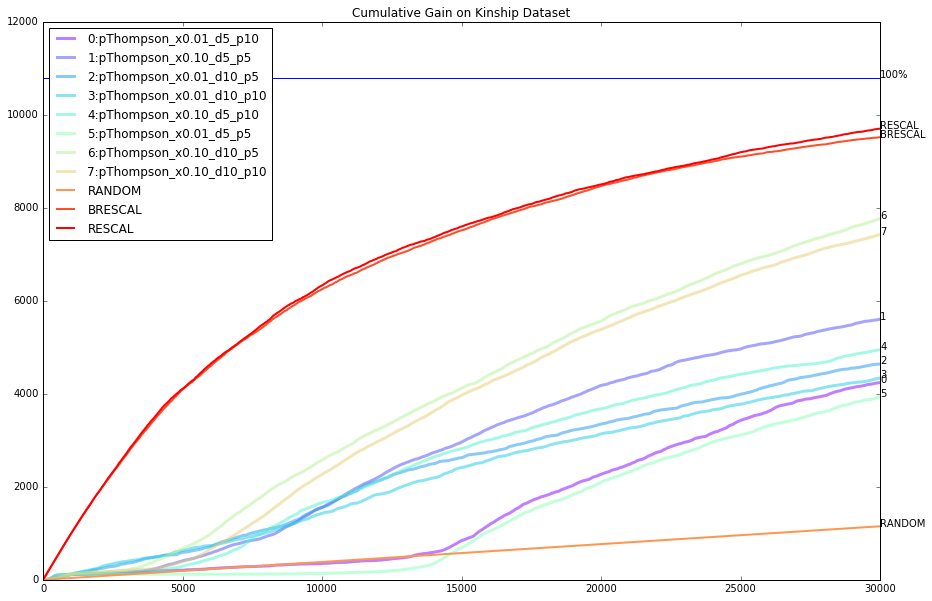

In [17]:
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(summary)+3)))
markers = iter(MarkerStyle.markers.keys())


for line_no, key in enumerate(summary.keys()):    
    stat = np.zeros([len(summary[key]), budget])
    cnt = 0
    for i, cum_sum in enumerate(summary[key]):
        try:
            stat[i] = cum_sum
            cnt += 1
        except:
            pass

    mean = np.sum(stat, 0)/cnt
    plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
             color=next(color), linewidth=3, alpha=0.5)
    plt.annotate(str(line_no), xy=(len(mean), mean[-1]))
    #plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)
    print('%d:pThompson_x%.2f_d%d_p%d:\tIteration: %5d\tGain: %5.1f' % (line_no, key[0], key[1], key[2], len(mean), mean[-1]))

print('BRESCAL:\tIteration: %5d\tGain: %5.1f' % (len(gain_brescal), np.cumsum(gain_brescal)[-1]))
print('RESCAL:\t\tIteration: %5d\tGain: %5.1f' % (len(gain_brescal), np.cumsum(gain_rescal)[-1]))

ratio = np.sum(T)/np.prod(T.shape)
cum_sum = np.cumsum([ratio for i in range(budget)])
plt.plot(cum_sum, label='RANDOM', color=next(color), linewidth=2)
plt.annotate('RANDOM', xy=(len(cum_sum), cum_sum[-1]))
plt.plot(np.cumsum(gain_brescal), label='BRESCAL', color=next(color), linewidth=2)
plt.annotate('BRESCAL', xy=(len(gain_brescal), np.cumsum(gain_brescal)[-1]))
plt.plot(np.cumsum(gain_rescal), label='RESCAL', color=next(color), linewidth=2)
plt.annotate('RESCAL', xy=(len(gain_rescal), np.cumsum(gain_rescal)[-1]))
plt.axhline(y=np.sum(T), xmin=0, xmax=budget)
plt.annotate('100%', xy=(budget, np.sum(T)))

plt.legend(loc=0)
plt.title('Cumulative Gain on Kinship Dataset')
plt.show()

All results are averaged over 10 individual runs. 
In general, 

* the models with 10 particles perform better than those with 5 particles. 
* And the models with 0.1 variance on observed data points perform better than those with 0.01 variance.

*Models with 30 particles are running now.*

## Plot Gain with One Standard Error

For clear representations, we only plot the cases where the number of particles is equal to 10.

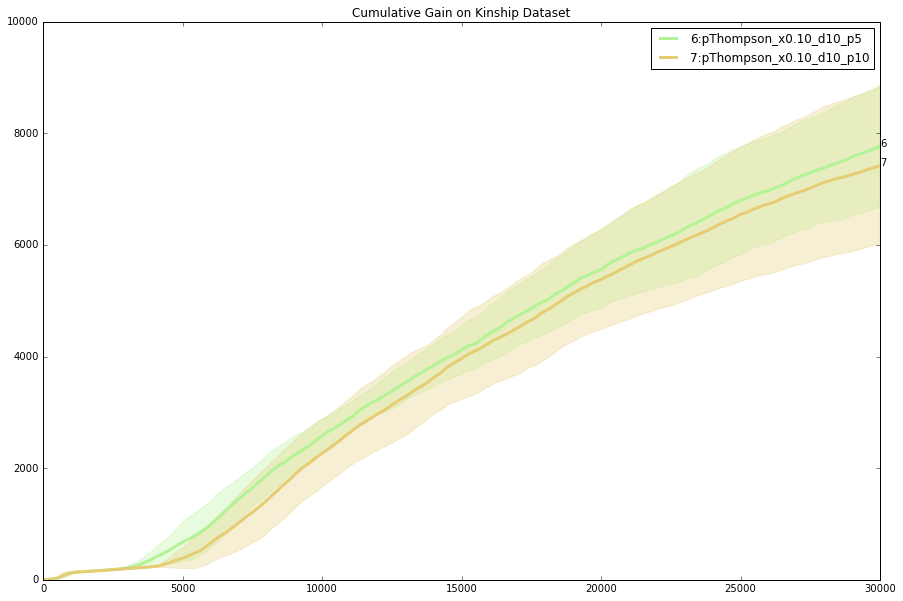

In [18]:
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(summary)+3)))
markers = iter(MarkerStyle.markers.keys())

for line_no, key in enumerate(summary.keys()):
    min_len = 999999999
    for cum_sum in summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(summary[key]), min_len])
    for i, cum_sum in enumerate(summary[key]):
        stat[i] = cum_sum[:min_len]
    c=next(color)    
    if key[0] == 0.10 and key[1] == 10:
        mean = np.mean(stat, 0)
        stderr = yerr=np.std(stat, 0)
        plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
                 color=c, linewidth=3)
        plt.annotate(str(line_no), xy=(len(mean), mean[-1]))
        plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)

plt.legend(loc=0)
plt.title('Cumulative Gain on Kinship Dataset')
plt.ylim((0,10000))
plt.show()

## Populating with RESCAL: Pure Explitation Process

Let's have another simple experiment. Now we try to populate the knowledge base with RESCAL only.
At time $t$, we train RESCAL with currently observed values of tensor (we set the value of unobserved triples to zero), and then choose next triples which has the highest expected value.

One can consider this expriment as a pure exploitation process.

In [19]:
dest = '../result/kinship/rescal/'
init_obs = [5, 100, 500]
rescal_populating_result = dict()
for nt, obs in itertools.product(range(10), init_obs):
    file = os.path.join(dest, 'init%d_rescal_n_dim_10_%d.txt'%(obs, nt))
    key = (nt, obs)
    if os.path.exists(file):
        seq = [line.split(',') for line in open(file, 'r').readlines()]
        key = (var_x, n_dim, n_particle)    
        cum_sum = np.cumsum([T[s] for s in seq])
        if obs not in rescal_populating_result:
            rescal_populating_result[obs] = list()
        rescal_populating_result[obs].append(cum_sum)

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


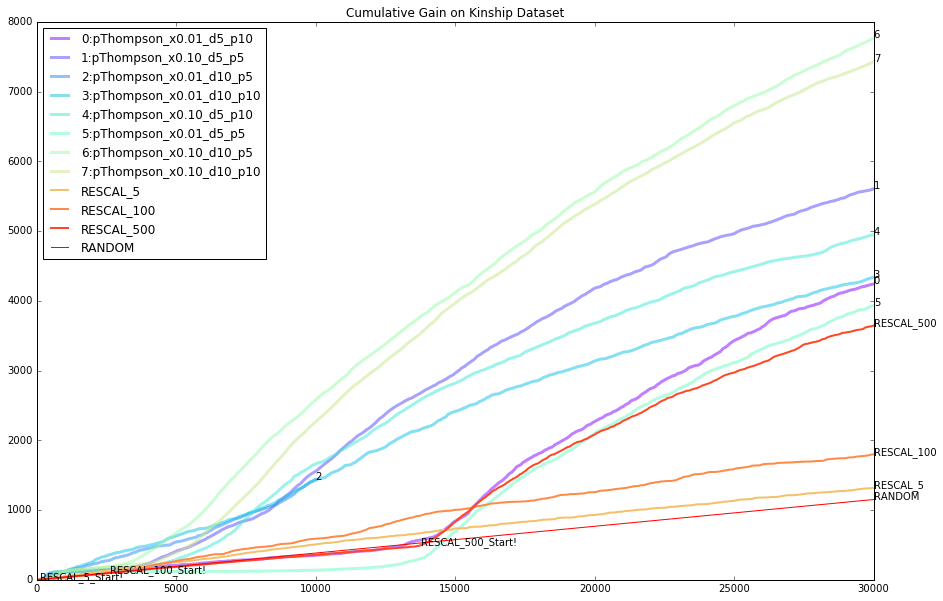

In [20]:
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(summary)+len(rescal_populating_result)+1)))
markers = iter(MarkerStyle.markers.keys())

for line_no, key in enumerate(summary.keys()):
    min_len = budget
    for cum_sum in summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(summary[key]), min_len])
    for i, cum_sum in enumerate(summary[key]):
        stat[i] = cum_sum[:min_len]
        
    mean = np.mean(stat, 0)
    plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
             color=next(color), linewidth=3, alpha=0.5)
    plt.annotate(str(line_no), xy=(len(mean), mean[-1]))

for obs in init_obs:
    rescal_cumsum = np.mean(rescal_populating_result[obs], 0)
    plt.plot(rescal_cumsum, label='RESCAL_%d' % (obs), color=next(color), linewidth=2)
    plt.annotate('RESCAL_%d' % (obs), xy=(budget, rescal_cumsum[budget-1]))
    idx = np.nonzero((rescal_cumsum) > obs)[0][0]
    plt.annotate('RESCAL_%d_Start!' % (obs), xy=(idx, obs))    

ratio = np.sum(T)/np.prod(T.shape)
cum_sum = np.cumsum([ratio for i in range(budget)])
plt.plot(cum_sum, label='RANDOM', color='r')
plt.annotate('RANDOM', xy=(budget, cum_sum[budget-1]))

plt.legend(loc=0)
plt.title('Cumulative Gain on Kinship Dataset')
plt.show()

## Single Case Analyze

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


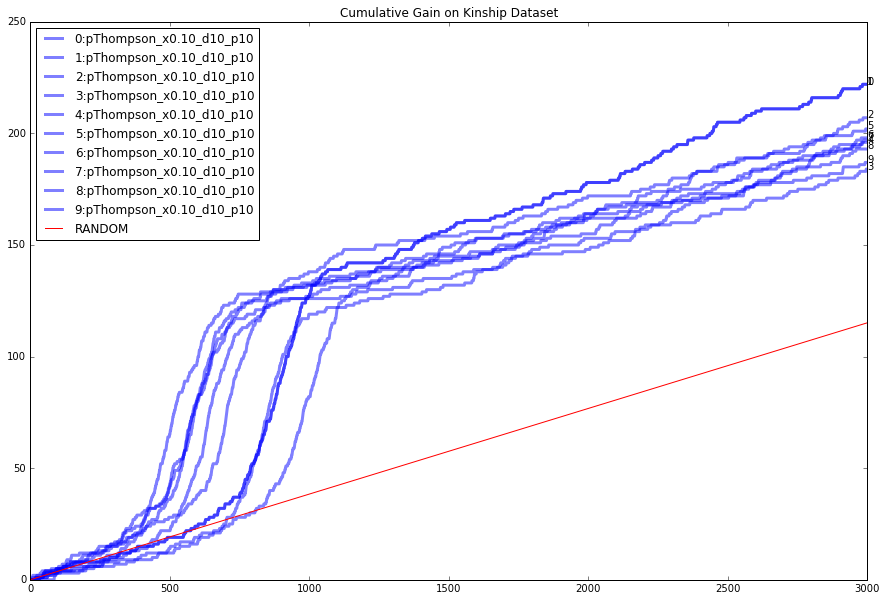

In [21]:
varxs = [0.1]
n_dims = [10]
n_particles = [10]
n_test = 10
x_lims = [3000]

for x_lim in x_lims:
    fig = plt.figure(figsize=(15,10))
    line_no=0
    dest = '../result/kinship/'
    for var_x, nt, n_dim, n_particle in itertools.product(varxs, range(n_test), n_dims, n_particles):
        file = os.path.join(dest, 'sRESCAL_varx_%.2f_dim_%d_par_%d_test_%d_convar_False.txt' % (var_x, n_dim, n_particle, nt))
        if os.path.exists(file):
            seq = [line.split(',') for line in open(file, 'r').readlines()]
            key = (var_x, n_dim, n_particle)    
            cum_sum = np.cumsum([T[s] for s in seq])

            plt.plot(cum_sum[:x_lim], label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
                 color='b', linewidth=3, alpha=0.5)
            plt.annotate(str(line_no), xy=(x_lim, cum_sum[x_lim]))                
            line_no+=1

    ratio = np.sum(T)/np.prod(T.shape)
    cum_sum = np.cumsum([ratio for i in range(x_lim)])
    plt.plot(cum_sum, label='RANDOM', color='r')

    plt.legend(loc=0)
    plt.title('Cumulative Gain on Kinship Dataset')
    plt.show()        

#### (WHY?) Relation 23 is a self citation relation which is fully discovered during 500 ~ 1000 iterations

## Compositional Relation

Now, we will add compositionality of relations into BRESCAL model.

In [22]:
varxs = [0.1]
n_dims = [10]
n_particles = [5, 10]
n_test = 10

dest = '../result/kinship_compositional/'
comp_summary = dict()

for var_x, nt, n_dim, n_particle in itertools.product(varxs, range(n_test+1), n_dims, n_particles):
    file = os.path.join(dest, 'sRESCAL_varx_%.2f_dim_%d_par_%d_test_%d_convar_False.txt' % (var_x, n_dim, n_particle, nt))
    if os.path.exists(file):
        seq = [line.split(',') for line in open(file, 'r').readlines()]
        key = (var_x, n_dim, n_particle)    
        cum_sum = np.cumsum([T[s] for s in seq])

        if not key in comp_summary:
            comp_summary[key] = list()
        comp_summary[key].append(cum_sum)


/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


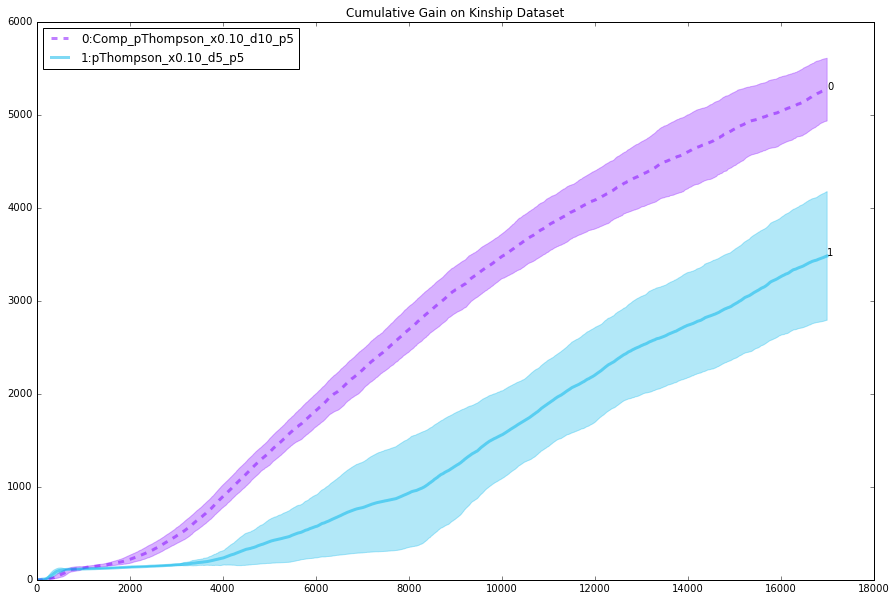

In [35]:
xlim = 17000
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(comp_summary)+len(summary)+3)))
markers = iter(MarkerStyle.markers.keys())

for line_no, key in enumerate(comp_summary.keys()):
    min_len = xlim
    for cum_sum in comp_summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(comp_summary[key]), min_len])
    for i, cum_sum in enumerate(comp_summary[key]):
        stat[i] = cum_sum[:min_len]
    c = next(color)
    mean = np.mean(stat, 0)
    stderr = yerr=np.std(stat, 0)
    if key[2] == 5: 
        plt.plot(mean, '--', label='%d:Comp_pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
                 color=c, linewidth=3, alpha=0.5)
        plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)
        plt.annotate(str(line_no), xy=(len(mean), mean[-1]))

for line_no, key in enumerate(summary.keys()):
    min_len = xlim
    for cum_sum in summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(summary[key]), min_len])
    for i, cum_sum in enumerate(summary[key]):
        stat[i] = cum_sum[:min_len]
    c = next(color)
    mean = np.mean(stat, 0)
    stderr = yerr=np.std(stat, 0)
    if key[0] == 0.1 and key[1] == 5 and key[2] == 5:
        plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
                 color=c, linewidth=3, alpha=0.5)
        plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)
        plt.annotate(str(line_no), xy=(len(mean), mean[-1]))

plt.legend(loc='upper left')
plt.ylim(ymin=0)
plt.title('Cumulative Gain on Kinship Dataset')
plt.show()        

# Result of Nation dataset 

In [2]:
mat = loadmat('../data/nation/dnations.mat')
T = np.array(mat['R'], np.float32)
T = np.swapaxes(T, 1, 2)
T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
T[np.isnan(T)] = 0

varxs = [0.1]
n_dims = [10]
n_particles = [5]
n_test = 10

dest = '../result/nation/compositional/'
comp_summary = dict()

for var_x, nt, n_dim, n_particle in itertools.product(varxs, range(n_test+1), n_dims, n_particles):
    file = os.path.join(dest, 'sRESCAL_varx_%.2f_dim_%d_par_%d_test_%d_convar_False.txt' % (var_x, n_dim, n_particle, nt))
    if os.path.exists(file):
        seq = [line.split(',') for line in open(file, 'r').readlines()]
        key = (var_x, n_dim, n_particle)    
        cum_sum = np.cumsum([T[s] for s in seq])

        if not key in comp_summary:
            comp_summary[key] = list()
        comp_summary[key].append(cum_sum)

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [4]:
dest = '../result/nation/normal/'
summary = dict()

for var_x, nt, n_dim, n_particle in itertools.product(varxs, range(n_test+1), n_dims, n_particles):
    file = os.path.join(dest, 'sRESCAL_varx_%.2f_dim_%d_par_%d_test_%d_convar_False.txt' % (var_x, n_dim, n_particle, nt))
    if os.path.exists(file):
        seq = [line.split(',') for line in open(file, 'r').readlines()]
        key = (var_x, n_dim, n_particle)    
        cum_sum = np.cumsum([T[s] for s in seq])

        if not key in summary:
            summary[key] = list()
        summary[key].append(cum_sum)

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


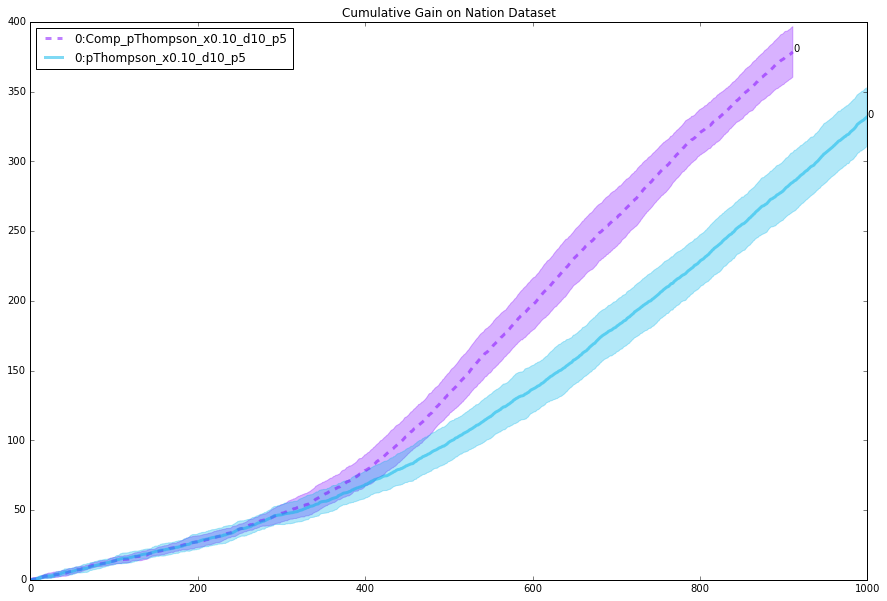

In [9]:
xlim = 1000
fig = plt.figure(figsize=(15,10))
color=iter(plt.cm.rainbow(np.linspace(0,1,len(comp_summary)+len(summary)+3)))
markers = iter(MarkerStyle.markers.keys())

for line_no, key in enumerate(comp_summary.keys()):
    min_len = xlim
    for cum_sum in comp_summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(comp_summary[key]), min_len])
    for i, cum_sum in enumerate(comp_summary[key]):
        stat[i] = cum_sum[:min_len]
    c = next(color)
    mean = np.mean(stat, 0)
    stderr = yerr=np.std(stat, 0)
    plt.plot(mean, '--', label='%d:Comp_pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
             color=c, linewidth=3, alpha=0.5)
    plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)
    plt.annotate(str(line_no), xy=(len(mean), mean[-1]))

for line_no, key in enumerate(summary.keys()):
    min_len = xlim
    for cum_sum in summary[key]:
        if len(cum_sum) < min_len:
            min_len = len(cum_sum)
    stat = np.zeros([len(summary[key]), min_len])
    for i, cum_sum in enumerate(summary[key]):
        stat[i] = cum_sum[:min_len]
    c = next(color)
    mean = np.mean(stat, 0)
    stderr = yerr=np.std(stat, 0)
    plt.plot(mean, label='%d:pThompson_x%.2f_d%d_p%d' % (line_no, key[0], key[1], key[2]), 
             color=c, linewidth=3, alpha=0.5)
    plt.fill_between(range(len(mean)), mean-stderr, mean+stderr, alpha=0.3, color=c)
    plt.annotate(str(line_no), xy=(len(mean), mean[-1]))

plt.legend(loc='upper left')
plt.ylim(ymin=0)
plt.title('Cumulative Gain on Nation Dataset')
plt.show()        